In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data

In [2]:
ticker = 'NVDA'
# ticker = 'IBM'
# ticker = 'INTC'
data = yf.download(ticker, start='2021-01-01', end='2024-10-13')

df = data[['Open', 'Close', 'Low', 'High', 'Volume']]
df

[*********************100%%**********************]  1 of 1 completed


,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


In [3]:
closeData = df.Close.values.astype('float32')

total_rows = closeData.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

XTrain = closeData[:train_end]
XValidation = closeData[train_end:validation_end]
XTest = closeData[validation_end:]

print("Training set size:", len(XTrain), f"({len(XTrain)/len(closeData)*100}%)")
print("Validation set size:", len(XValidation), f"({len(XValidation)/len(closeData)*100}%)")
print("Test set size:", len(XTest), f"({len(XTest)/len(closeData)*100}%)")

Training set size: 665 (70.0%)
Validation set size: 190 (20.0%)
Test set size: 95 (10.0%)


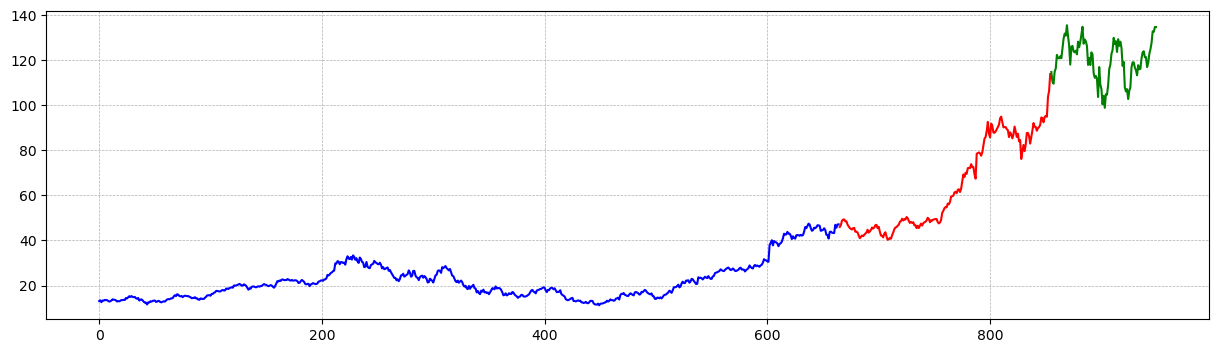

In [4]:
plt.figure(figsize=(15,4))

# plt.plot(openData, color='gray')
plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show() 

## Processing data

In [5]:
closeData.shape

(950,)

In [6]:
closeData = closeData.reshape(-1,1)
XTrain = XTrain.reshape(-1,1)
XValidation = XValidation.reshape(-1,1)
XTest = XTest.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(closeData)

openData = scaler.transform(closeData)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)

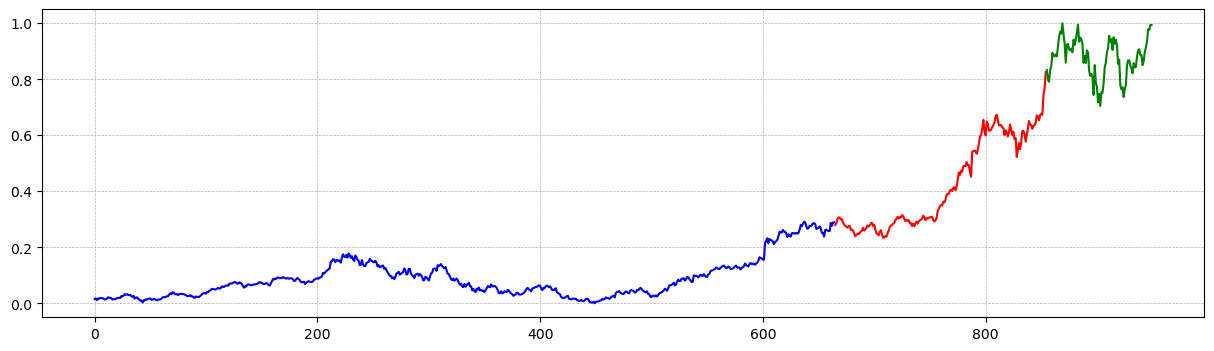

In [7]:
plt.figure(figsize=(15,4))

plt.plot(XTrain, color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), XValidation, color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), XTest, color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

# Many-to-one

In [8]:
def create_lookback(dataset, lookback, device):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        after_window = dataset[i + lookback]
        X.append(window)
        y.append(after_window)
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    return X_tensor, y_tensor

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
lookback = 10
XTrain_tensor, TTrain_tensor = create_lookback(XTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback(XValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback(XTest, lookback, device)

Timeseries_tensor, TTimeseries_tensor = create_lookback(openData, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([655, 10, 1]), 
TTrain_tensor shape: torch.Size([655, 1])

XValidation_tensor shape: torch.Size([180, 10, 1]), 
TValidation_tensor shape: torch.Size([180, 1])

XTest_tensor shape: torch.Size([85, 10, 1]), 
TTest_tensor shape: torch.Size([85, 1])


In [11]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

21
6
3


In [12]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 5e-4
n_epochs = 100
# early_stop_patience = 10


model_lstm = LSTMModel().to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

model_gru = GRUModel().to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)


train_hist_lstm, val_hist_lstm = [], []
train_hist_gru, val_hist_gru = [], []


def calculate_rmse(predicted, observed):
    rmses = np.sqrt(np.mean((predicted - observed) ** 2, axis=0))
    rmse_mean = np.mean(rmses)
    return rmse_mean, rmses


min_val_loss_lstm = float('inf')
early_stop_count_lstm = 0

for epoch in range(n_epochs):
    model_lstm.train()
    total_loss_lstm = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_lstm.zero_grad()
        y_pred = model_lstm(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_lstm.step()
        
        total_loss_lstm += loss.item()

    average_loss_lstm = total_loss_lstm / len(train_loader)
    train_hist_lstm.append(average_loss_lstm)

    model_lstm.eval()
    total_val_loss_lstm = 0.0
    y_predicted_lstm, y_observed_lstm = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_lstm(X_batch)
            y_predicted_lstm.append(y_pred.cpu().numpy())
            y_observed_lstm.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_lstm += val_loss.item()

    average_val_loss_lstm = total_val_loss_lstm / len(val_loader)
    val_hist_lstm.append(average_val_loss_lstm)

    # if average_val_loss_lstm < min_val_loss_lstm:
    #     min_val_loss_lstm = average_val_loss_lstm
    #     early_stop_count_lstm = 0
    # else:
    #     early_stop_count_lstm += 1

    # if early_stop_count_lstm >= early_stop_patience:
    #     print(f'Early stopping for LSTM at epoch {epoch+1}')
    #     break


model_lstm.eval()
with torch.no_grad():
    y_pred_test_lstm = model_lstm(Timeseries_tensor)

predicted_lstm = scaler.inverse_transform(y_pred_test_lstm.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())
rmse_mean_lstm, rmses_lstm = calculate_rmse(predicted_lstm, observed)
print(f"RMSE promedio LSTM: {rmse_mean_lstm}")


min_val_loss_gru = float('inf')
early_stop_count_gru = 0

for epoch in range(n_epochs):
    model_gru.train()
    total_loss_gru = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_gru.zero_grad()
        y_pred = model_gru(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_gru.step()
        
        total_loss_gru += loss.item()

    average_loss_gru = total_loss_gru / len(train_loader)
    train_hist_gru.append(average_loss_gru)

    model_gru.eval()
    total_val_loss_gru = 0.0
    y_predicted_gru, y_observed_gru = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_gru(X_batch)
            y_predicted_gru.append(y_pred.cpu().numpy())
            y_observed_gru.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_gru += val_loss.item()

    average_val_loss_gru = total_val_loss_gru / len(val_loader)
    val_hist_gru.append(average_val_loss_gru)

    # if average_val_loss_gru < min_val_loss_gru:
    #     min_val_loss_gru = average_val_loss_gru
    #     early_stop_count_gru = 0
    # else:
    #     early_stop_count_gru += 1

    # if early_stop_count_gru >= early_stop_patience:
    #     print(f'Early stopping for GRU at epoch {epoch+1}')
    #     break


model_gru.eval()
with torch.no_grad():
    y_pred_test_gru = model_gru(Timeseries_tensor)

predicted_gru = scaler.inverse_transform(y_pred_test_gru.cpu().numpy())
rmse_mean_gru, rmses_gru = calculate_rmse(predicted_gru, observed)
print(f"RMSE promedio GRU: {rmse_mean_gru}")


RMSE promedio LSTM: 2.641676187515259
RMSE promedio GRU: 3.0409996509552


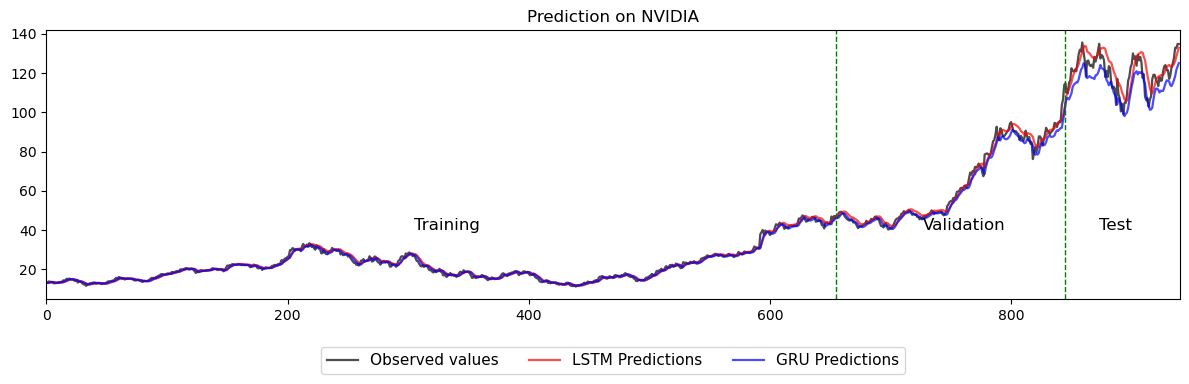

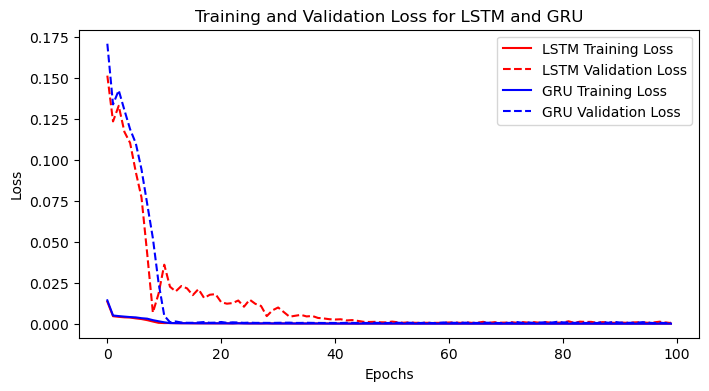

In [13]:
# Gráficas de comparación de funciones de pérdida y predicciones
plt.figure(figsize=(12, 4))
plt.plot(observed, color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(predicted_lstm, label='LSTM Predictions', linestyle='-', color="red", linewidth=1.6, alpha=0.7)
plt.plot(predicted_gru, label='GRU Predictions', linestyle='-', color="blue", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain)-lookback, color='green', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='green', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.4, 'Training', fontsize=12, color='black', ha='center')
plt.text(33+len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.4, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.4, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title('Prediction on NVIDIA')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
# plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_hist_lstm, label='LSTM Training Loss', color='red')
plt.plot(val_hist_lstm, label='LSTM Validation Loss', color='red', linestyle='--')
plt.plot(train_hist_gru, label='GRU Training Loss', color='blue')
plt.plot(val_hist_gru, label='GRU Validation Loss', color='blue', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM and GRU')
plt.legend()
# plt.grid(True)
plt.show()

# Predicting the price with multivariate LSTM model
## (Many-to-one)

In [14]:
df

,Open,Close,Low,High,Volume
Date,,,,,
2021-01-04,13.104250,13.113500,12.962500,13.652500,560640000
2021-01-05,13.099750,13.404750,13.087000,13.443500,322760000
2021-01-06,13.222500,12.614500,12.586000,13.245000,580424000
2021-01-07,12.967500,13.344000,12.886500,13.377750,461480000
2021-01-08,13.362500,13.276750,13.042000,13.421000,292528000
...,...,...,...,...,...
2024-10-07,124.989998,127.720001,124.949997,130.639999,346250200
2024-10-08,130.259995,132.889999,129.419998,133.479996,285722500
2024-10-09,134.110001,132.649994,131.380005,134.520004,246191600


Now, our prediction consist of all the orhers columns except our target (Close in our case).

In [15]:
X, y = df.drop(columns=['Close', 'Volume']), df.Close.values
# X, y = df, df.Close.values
X.shape, y.shape

((950, 3), (950,))

In [16]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [17]:
total_rows = X_trans.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

# variables
XTrain = X_trans[:train_end]
XValidation = X_trans[train_end:validation_end]
XTest = X_trans[validation_end:]

# target
TTrain = y_trans[:train_end]
TValidation = y_trans[train_end:validation_end]
TTest = y_trans[validation_end:]

In [18]:
def create_lookback_many_to_one(input_sequences, output_sequence, lookback, device):
    """
    Prepares the dataset for a many-to-one LSTM model, where each input sequence has 
    a corresponding single target value from a separate output sequence.
    
    Parameters:
        input_sequences (array-like): The input time series data.
        output_sequence (array-like): The target time series data.
        lookback (int): Number of previous time steps to consider for each prediction.
        device (str): The device on which tensors should be stored ('cpu' or 'cuda').
        
    Returns:
        X_tensor (torch.Tensor): Tensor of input sequences with shape (num_samples, lookback, num_features).
        y_tensor (torch.Tensor): Tensor of target values with shape (num_samples,).
    """
    X, y = [], []
    for i in range(len(input_sequences) - lookback):
        # Extract a window of length `lookback` from `input_sequences`
        window = input_sequences[i:(i + lookback)]
        # Target is the single value from `output_sequence` after the window
        target_value = output_sequence[i + lookback]
        
        X.append(window)
        y.append(target_value)
    
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    return X_tensor, y_tensor


In [19]:
lookback = 50
XTrain_tensor, TTrain_tensor = create_lookback_many_to_one(XTrain, TTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback_many_to_one(XValidation, TValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback_many_to_one(XTest, TTest, lookback, device)
Timeseries_tensor, TTimeseries_tensor = create_lookback_many_to_one(X_trans, y_trans, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([615, 50, 3]), 
TTrain_tensor shape: torch.Size([615, 1])

XValidation_tensor shape: torch.Size([140, 50, 3]), 
TValidation_tensor shape: torch.Size([140, 1])

XTest_tensor shape: torch.Size([45, 50, 3]), 
TTest_tensor shape: torch.Size([45, 1])


In [20]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

39
5
2


RMSE promedio LSTM: 2.3412904739379883
RMSE promedio GRU: 2.934493064880371


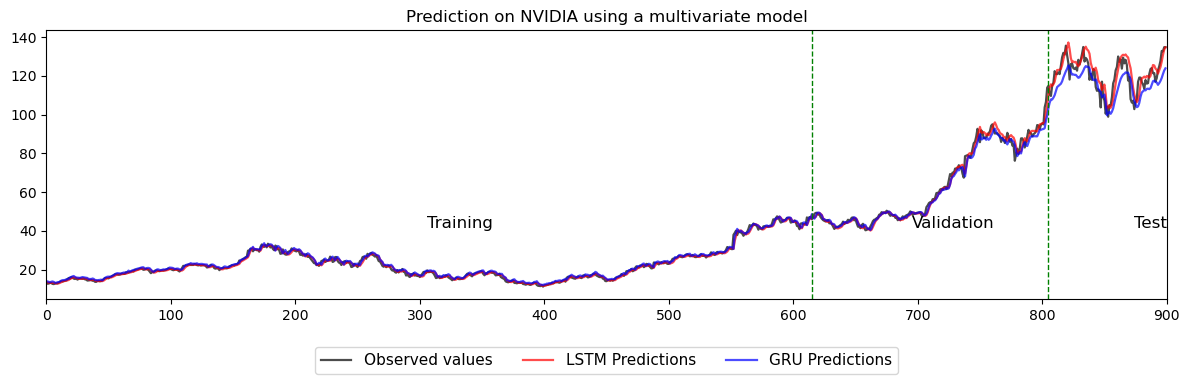

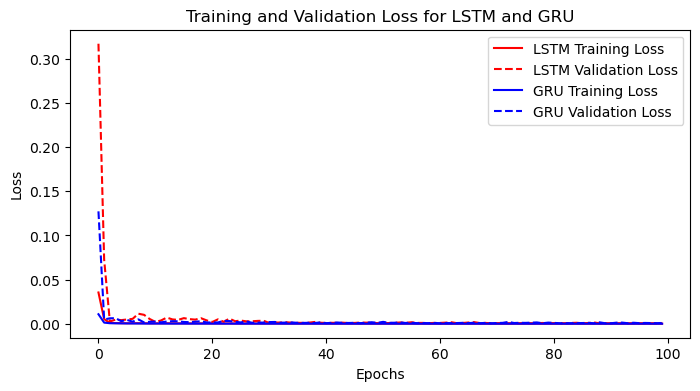

In [21]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 16)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=3, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 16)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 5e-4
n_epochs = 100
# early_stop_patience = 10

model_lstm = LSTMModel().to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

model_gru = GRUModel().to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

train_hist_lstm, val_hist_lstm = [], []
train_hist_gru, val_hist_gru = [], []

def calculate_rmse(predicted, observed):
    rmses = np.sqrt(np.mean((predicted - observed) ** 2, axis=0))
    rmse_mean = np.mean(rmses)
    return rmse_mean, rmses

min_val_loss_lstm = float('inf')
early_stop_count_lstm = 0

for epoch in range(n_epochs):
    model_lstm.train()
    total_loss_lstm = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_lstm.zero_grad()
        y_pred = model_lstm(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_lstm.step()
        
        total_loss_lstm += loss.item()

    average_loss_lstm = total_loss_lstm / len(train_loader)
    train_hist_lstm.append(average_loss_lstm)

    model_lstm.eval()
    total_val_loss_lstm = 0.0
    y_predicted_lstm, y_observed_lstm = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_lstm(X_batch)
            y_predicted_lstm.append(y_pred.cpu().numpy())
            y_observed_lstm.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_lstm += val_loss.item()

    average_val_loss_lstm = total_val_loss_lstm / len(val_loader)
    val_hist_lstm.append(average_val_loss_lstm)

    # if average_val_loss_lstm < min_val_loss_lstm:
    #     min_val_loss_lstm = average_val_loss_lstm
    #     early_stop_count_lstm = 0
    # else:
    #     early_stop_count_lstm += 1

    # if early_stop_count_lstm >= early_stop_patience:
    #     print(f'Early stopping for LSTM at epoch {epoch+1}')
    #     break

model_lstm.eval()
with torch.no_grad():
    y_pred_test_lstm = model_lstm(Timeseries_tensor)

predicted_lstm = scaler.inverse_transform(y_pred_test_lstm.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())
rmse_mean_lstm, rmses_lstm = calculate_rmse(predicted_lstm, observed)
print(f"RMSE promedio LSTM: {rmse_mean_lstm}")

min_val_loss_gru = float('inf')
# early_stop_count_gru = 10

for epoch in range(n_epochs):
    model_gru.train()
    total_loss_gru = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_gru.zero_grad()
        y_pred = model_gru(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_gru.step()
        
        total_loss_gru += loss.item()

    average_loss_gru = total_loss_gru / len(train_loader)
    train_hist_gru.append(average_loss_gru)

    model_gru.eval()
    total_val_loss_gru = 0.0
    y_predicted_gru, y_observed_gru = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_gru(X_batch)
            y_predicted_gru.append(y_pred.cpu().numpy())
            y_observed_gru.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_gru += val_loss.item()

    average_val_loss_gru = total_val_loss_gru / len(val_loader)
    val_hist_gru.append(average_val_loss_gru)

    # if average_val_loss_gru < min_val_loss_gru:
    #     min_val_loss_gru = average_val_loss_gru
    #     early_stop_count_gru = 0
    # else:
    #     early_stop_count_gru += 1

    # if early_stop_count_gru >= early_stop_patience:
    #     print(f'Early stopping for GRU at epoch {epoch+1}')
    #     break


model_gru.eval()
with torch.no_grad():
    y_pred_test_gru = model_gru(Timeseries_tensor)

predicted_gru = scaler.inverse_transform(y_pred_test_gru.cpu().numpy())
rmse_mean_gru, rmses_gru = calculate_rmse(predicted_gru, observed)
print(f"RMSE promedio GRU: {rmse_mean_gru}")

plt.figure(figsize=(12, 4))
plt.plot(observed, color='k', linewidth=1.6, alpha=.7, label='Observed values')
plt.plot(predicted_lstm, label='LSTM Predictions', linestyle='-', color="red", linewidth=1.6, alpha=0.7)
plt.plot(predicted_gru, label='GRU Predictions', linestyle='-', color="blue", linewidth=1.6, alpha=0.7)

plt.axvline(x=len(XTrain)-lookback, color='green', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='green', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title('Prediction on NVIDIA using a multivariate model')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(train_hist_lstm, label='LSTM Training Loss', color='red')
plt.plot(val_hist_lstm, label='LSTM Validation Loss', color='red', linestyle='--')
plt.plot(train_hist_gru, label='GRU Training Loss', color='blue')
plt.plot(val_hist_gru, label='GRU Validation Loss', color='blue', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM and GRU')
plt.legend()
plt.show()


# Many-to-many

In [22]:
def split_sequences(input_sequences, output_sequences, n_steps_in, n_steps_out, device):
    X, y = [], []
    for i in range(len(input_sequences)):
        # Define the end of this input sequence
        end_ix = i + n_steps_in
        # Define the end of the output sequence
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(input_sequences):
            break
        # Input and output sequences
        seq_x = input_sequences[i:end_ix]
        seq_y = output_sequences[end_ix:out_end_ix]  # Note: No '-1' here
        X.append(seq_x)
        y.append(seq_y)
    # Convert lists to tensors and move to specified device
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    
    return X_tensor, y_tensor


In [23]:
closeData = df.Close.values.astype('float32')

total_rows = closeData.shape[0]
train_end = int(total_rows * 0.7)
validation_end = int(total_rows * 0.9)

XTrain = closeData[:train_end]
XValidation = closeData[train_end:validation_end]
XTest = closeData[validation_end:]

print("Training set size:", len(XTrain), f"({len(XTrain)/len(closeData)*100}%)")
print("Validation set size:", len(XValidation), f"({len(XValidation)/len(closeData)*100}%)")
print("Test set size:", len(XTest), f"({len(XTest)/len(closeData)*100}%)")


closeData = closeData.reshape(-1,1)
XTrain = XTrain.reshape(-1,1)
XValidation = XValidation.reshape(-1,1)
XTest = XTest.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(closeData)

closeData = scaler.transform(closeData)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)


XTrain_tensor, TTrain_tensor  = split_sequences(XTrain, XTrain, 50, 30, device)
XValidation_tensor, TValidation_tensor = split_sequences(XValidation, XValidation, 50, 30, device)
XTest_tensor, TTest_tensor = split_sequences(XTest, XTest, 50, 30, device)
Timeseries_tensor, TTimeseries_tensor = split_sequences(closeData, closeData, 50, 30, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

Training set size: 665 (70.0%)
Validation set size: 190 (20.0%)
Test set size: 95 (10.0%)
XTrain_tensor shape: torch.Size([586, 50, 1]), 
TTrain_tensor shape: torch.Size([586, 30, 1])

XValidation_tensor shape: torch.Size([111, 50, 1]), 
TValidation_tensor shape: torch.Size([111, 30, 1])

XTest_tensor shape: torch.Size([16, 50, 1]), 
TTest_tensor shape: torch.Size([16, 30, 1])


In [ ]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shPuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

37
4
1


In [25]:
class MultiStepLSTMModel(nn.Module):
    def __init__(self, n_steps_out):
        super(MultiStepLSTMModel, self).__init__()
        
        self.n_steps_out = n_steps_out
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, self.n_steps_out)  

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        
        out = self.dropout(output[:, -1, :])  # (batch_size, hidden_size)
        out = self.fc1(out)
        out = self.fc2(out)  # (batch_size, n_steps_out)
        
        # Reformat to (batch_size, n_steps_out, 1) for multistep prediction
        out = out.view(-1, self.n_steps_out, 1)
        return out

class MultiStepGRUModel(nn.Module):
    def __init__(self, n_steps_out):
        super(MultiStepGRUModel, self).__init__()
        
        self.n_steps_out = n_steps_out
        
        self.gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, self.n_steps_out)  

    def forward(self, x):
        output, hn = self.gru(x)
        
        out = self.dropout(output[:, -1, :])  
        out = self.fc1(out)
        out = self.fc2(out)  
        
        out = out.view(-1, self.n_steps_out, 1)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 5e-4
n_epochs = 100
# early_stop_patience = 10

input_size = XTrain_tensor.shape[2]
output_size = TTrain_tensor.shape[2]
n_steps_out = TTrain_tensor.shape[1]

model_lstm = MultiStepLSTMModel(n_steps_out).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

model_gru = MultiStepGRUModel(n_steps_out).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

train_hist_lstm, val_hist_lstm = [], []
train_hist_gru, val_hist_gru = [], []

def calculate_rmse(predicted, observed):
    rmses = np.sqrt(np.mean((predicted - observed) ** 2, axis=0))
    rmse_mean = np.mean(rmses)
    return rmse_mean, rmses

min_val_loss_lstm = float('inf')
early_stop_count_lstm = 0

for epoch in range(n_epochs):
    model_lstm.train()
    total_loss_lstm = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_lstm.zero_grad()
        y_pred = model_lstm(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_lstm.step()
        
        total_loss_lstm += loss.item()

    average_loss_lstm = total_loss_lstm / len(train_loader)
    train_hist_lstm.append(average_loss_lstm)

    model_lstm.eval()
    total_val_loss_lstm = 0.0
    y_predicted_lstm, y_observed_lstm = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_lstm(X_batch)
            y_predicted_lstm.append(y_pred.cpu().numpy())
            y_observed_lstm.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_lstm += val_loss.item()

    average_val_loss_lstm = total_val_loss_lstm / len(val_loader)
    val_hist_lstm.append(average_val_loss_lstm)

    # if average_val_loss_lstm < min_val_loss_lstm:
    #     min_val_loss_lstm = average_val_loss_lstm
    #     early_stop_count_lstm = 0
    # else:
    #     early_stop_count_lstm += 1

    # if early_stop_count_lstm >= early_stop_patience:
    #     print(f'Early stopping for LSTM at epoch {epoch+1}')
    #     break

model_lstm.eval()
with torch.no_grad():
    y_pred_test_lstm = model_lstm(Timeseries_tensor)

predicted_lstm = scaler.inverse_transform(y_pred_test_lstm.cpu().numpy().reshape(-1, output_size * n_steps_out))
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy().reshape(-1, output_size * n_steps_out))
rmse_mean_lstm, rmses_lstm = calculate_rmse(predicted_lstm, observed)
print(f"RMSE promedio LSTM multistep: {rmse_mean_lstm}")

min_val_loss_gru = float('inf')
early_stop_count_gru = 0

for epoch in range(n_epochs):
    model_gru.train()
    total_loss_gru = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer_gru.zero_grad()
        y_pred = model_gru(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer_gru.step()
        
        total_loss_gru += loss.item()

    average_loss_gru = total_loss_gru / len(train_loader)
    train_hist_gru.append(average_loss_gru)

    model_gru.eval()
    total_val_loss_gru = 0.0
    y_predicted_gru, y_observed_gru = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model_gru(X_batch)
            y_predicted_gru.append(y_pred.cpu().numpy())
            y_observed_gru.append(y_batch.cpu().numpy())
            
            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss_gru += val_loss.item()

    average_val_loss_gru = total_val_loss_gru / len(val_loader)
    val_hist_gru.append(average_val_loss_gru)

    # if average_val_loss_gru < min_val_loss_gru:
    #     min_val_loss_gru = average_val_loss_gru
    #     early_stop_count_gru = 0
    # else:
    #     early_stop_count_gru += 1

    # if early_stop_count_gru >= early_stop_patience:
    #     print(f'Early stopping for GRU at epoch {epoch+1}')
    #     break

model_gru.eval()
with torch.no_grad():
    y_pred_test_gru = model_gru(Timeseries_tensor)

predicted_gru = scaler.inverse_transform(y_pred_test_gru.cpu().numpy().reshape(-1, output_size * n_steps_out))
rmse_mean_gru, rmses_gru = calculate_rmse(predicted_gru, observed)
print(f"RMSE promedio GRU multistep: {rmse_mean_gru}")


RMSE promedio LSTM multistep: 12.701180458068848
RMSE promedio GRU multistep: 10.247328758239746


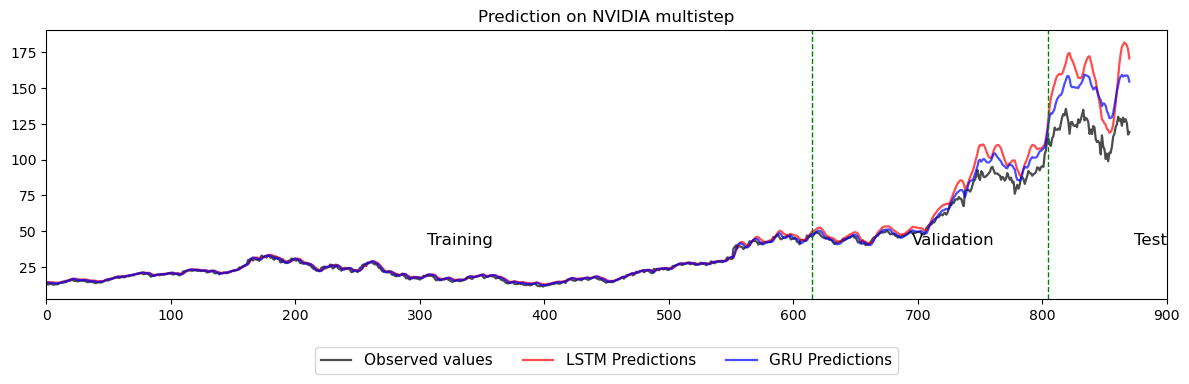

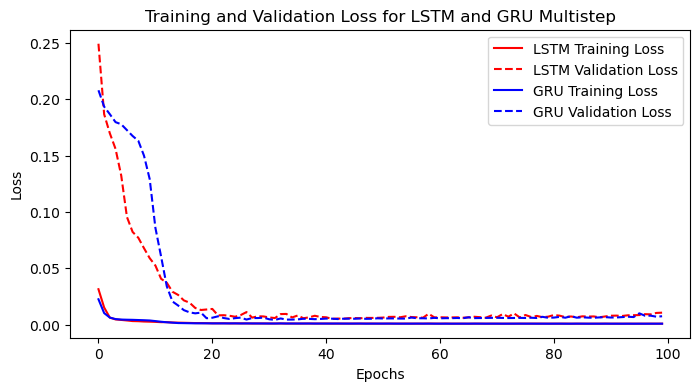

In [26]:
plt.figure(figsize=(12, 4))

# Graficar valores observados (variable objetivo real)
plt.plot(observed[:, 0], color='k', linewidth=1.6, alpha=.7, label='Observed values')

# Graficar predicciones multistep del LSTM (promedio de todos los pasos futuros)
plt.plot(np.mean(predicted_lstm, axis=1), label='LSTM Predictions', linestyle='-', color="red", linewidth=1.6, alpha=0.7)

# Graficar predicciones multistep del GRU (promedio de todos los pasos futuros)
plt.plot(np.mean(predicted_gru, axis=1), label='GRU Predictions', linestyle='-', color="blue", linewidth=1.6, alpha=0.7)

# Divisiones para Training, Validation y Test
plt.axvline(x=len(XTrain)-lookback, color='green', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='green', linestyle='--', linewidth=1)

plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title('Prediction on NVIDIA multistep')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(train_hist_lstm, label='LSTM Training Loss', color='red')
plt.plot(val_hist_lstm, label='LSTM Validation Loss', color='red', linestyle='--')
plt.plot(train_hist_gru, label='GRU Training Loss', color='blue')
plt.plot(val_hist_gru, label='GRU Validation Loss', color='blue', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM and GRU Multistep')
plt.legend()
# plt.grid(True)
plt.show()
